# 📌RNN & LSTM 실습

## 1. 기본 설정

In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN, SimpleRNN

tf.keras.backend.set_floatx('float64')

In [27]:
train = pd.read_csv('energy/train.csv', encoding='CP949')
test = pd.read_csv('energy/test.csv', encoding='CP949')
submission = pd.read_csv('energy/sample_submission.csv')

In [28]:
train = train[train['num']==6]

In [29]:
test6 = train.iloc[1872:, :]
train = train.iloc[:1872, :]

In [30]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
10200,6,2020-06-01 00,527.58,17.0,2.0,100.0,1.1,0.0,0.0,0.0
10201,6,2020-06-01 01,518.94,17.2,2.3,99.0,0.1,0.0,0.0,0.0
10202,6,2020-06-01 02,511.38,17.2,3.7,98.0,0.0,0.0,0.0,0.0
10203,6,2020-06-01 03,514.62,16.7,3.1,99.0,0.0,0.0,0.0,0.0
10204,6,2020-06-01 04,503.82,16.9,3.5,98.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12067,6,2020-08-17 19,802.98,29.1,2.4,78.0,0.0,0.7,0.0,0.0
12068,6,2020-08-17 20,760.32,27.6,1.1,84.0,0.0,0.0,0.0,0.0
12069,6,2020-08-17 21,692.28,26.5,0.9,89.0,0.0,0.0,0.0,0.0
12070,6,2020-08-17 22,641.52,25.8,0.3,91.0,0.0,0.0,0.0,0.0


In [31]:
test6

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
12072,6,2020-08-18 00,596.70,25.2,0.6,95.0,0.0,0.0,0.0,0.0
12073,6,2020-08-18 01,585.90,24.5,0.7,97.0,0.0,0.0,0.0,0.0
12074,6,2020-08-18 02,582.12,24.3,0.5,98.0,0.0,0.0,0.0,0.0
12075,6,2020-08-18 03,570.24,23.9,0.4,99.0,0.0,0.0,0.0,0.0
12076,6,2020-08-18 04,565.92,23.7,0.2,100.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12235,6,2020-08-24 19,1399.14,29.2,1.0,72.0,0.0,0.6,0.0,0.0
12236,6,2020-08-24 20,1124.82,28.0,0.1,79.0,0.0,0.0,0.0,0.0
12237,6,2020-08-24 21,905.58,27.6,0.1,82.0,0.0,0.0,0.0,0.0
12238,6,2020-08-24 22,790.02,27.5,0.4,84.0,0.0,0.0,0.0,0.0


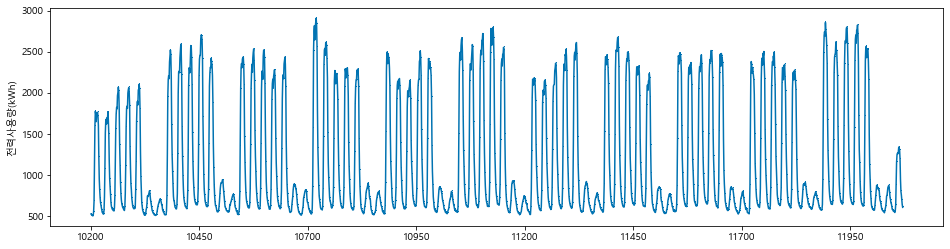

In [32]:
train_ep = train['전력사용량(kWh)']

plt.rc('font', family='Malgun Gothic')

plot_series(train_ep, markers=[','])
plt.show()

## 2. 데이터 전처리

In [33]:
# MinMax Scaling

mini = train.iloc[:,2].min()
size = train.iloc[:,2].max()-train.iloc[:,2].min()
train.iloc[:,2] = (train.iloc[:,2]-mini)/size

In [34]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
10200,6,2020-06-01 00,0.009888,17.0,2.0,100.0,1.1,0.0,0.0,0.0
10201,6,2020-06-01 01,0.006292,17.2,2.3,99.0,0.1,0.0,0.0,0.0
10202,6,2020-06-01 02,0.003146,17.2,3.7,98.0,0.0,0.0,0.0,0.0
10203,6,2020-06-01 03,0.004494,16.7,3.1,99.0,0.0,0.0,0.0,0.0
10204,6,2020-06-01 04,0.000000,16.9,3.5,98.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12067,6,2020-08-17 19,0.124494,29.1,2.4,78.0,0.0,0.7,0.0,0.0
12068,6,2020-08-17 20,0.106742,27.6,1.1,84.0,0.0,0.0,0.0,0.0
12069,6,2020-08-17 21,0.078427,26.5,0.9,89.0,0.0,0.0,0.0,0.0
12070,6,2020-08-17 22,0.057303,25.8,0.3,91.0,0.0,0.0,0.0,0.0


In [35]:
train_x = tf.reshape(train.iloc[:, 2].values, [24*78, 1])
print(f'train_x.shape:{train_x.shape}')

train_x.shape:(1872, 1)


In [36]:
train_x

<tf.Tensor: shape=(1872, 1), dtype=float64, numpy=
array([[0.00988764],
       [0.00629213],
       [0.00314607],
       ...,
       [0.07842697],
       [0.05730337],
       [0.04337079]])>

In [37]:
input_window = 216
output_window = 24
window = 12
num_features = 1

In [38]:
train_window_x = np.zeros((((train_x.shape[0]-(input_window + output_window))//window)+1, input_window, num_features))
train_window_y = np.zeros((((train_x.shape[0]-(input_window + output_window))//window)+1, output_window, num_features))
print(f'train_window_x.shape:{train_window_x.shape}')
print(f'train_window_y.shape:{train_window_y.shape}')

train_window_x.shape:(137, 216, 1)
train_window_y.shape:(137, 24, 1)


In [39]:
for start in range(0, (train_x.shape[0]-(input_window+output_window))+1, window):
    end = start+input_window
    train_window_x[start//window, :] = train_x[start: end               , :]
    train_window_y[start//window, :] = train_x[end  : end+ output_window, :]

In [40]:
train_window_x

array([[[0.00988764],
        [0.00629213],
        [0.00314607],
        ...,
        [0.13483146],
        [0.09101124],
        [0.0752809 ]],

       [[0.47685393],
        [0.5211236 ],
        [0.51325843],
        ...,
        [0.65595506],
        [0.74921348],
        [0.74539326]],

       [[0.04044944],
        [0.02786517],
        [0.01730337],
        ...,
        [0.14314607],
        [0.10674157],
        [0.08224719]],

       ...,

       [[0.06067416],
        [0.05348315],
        [0.05033708],
        ...,
        [0.05977528],
        [0.0458427 ],
        [0.03370787]],

       [[0.68831461],
        [0.73101124],
        [0.73730337],
        ...,
        [0.06876404],
        [0.10044944],
        [0.10539326]],

       [[0.06089888],
        [0.0505618 ],
        [0.05011236],
        ...,
        [0.06157303],
        [0.04696629],
        [0.03325843]]])

In [41]:
train_window_y

array([[[0.0611236 ],
        [0.05011236],
        [0.04606742],
        ...,
        [0.14314607],
        [0.10674157],
        [0.08224719]],

       [[0.72404494],
        [0.79595506],
        [0.86179775],
        ...,
        [0.70561798],
        [0.79280899],
        [0.81191011]],

       [[0.07168539],
        [0.06539326],
        [0.05820225],
        ...,
        [0.1341573 ],
        [0.10404494],
        [0.07595506]],

       ...,

       [[0.03146067],
        [0.02561798],
        [0.02449438],
        ...,
        [0.06157303],
        [0.04696629],
        [0.03325843]],

       [[0.12651685],
        [0.14426966],
        [0.15011236],
        ...,
        [0.27123596],
        [0.30898876],
        [0.31730337]],

       [[0.03146067],
        [0.02741573],
        [0.02292135],
        ...,
        [0.07842697],
        [0.05730337],
        [0.04337079]]])

In [42]:
print(f'train_window_x.shape:{train_window_x.shape}')
print(f'train_window_y.shape:{train_window_y.shape}')

train_window_x.shape:(137, 216, 1)
train_window_y.shape:(137, 24, 1)


## 3. RNN

In [18]:
tf.random.set_seed(0)

model = Sequential([
    SimpleRNN(64, return_sequences=False, recurrent_dropout=0.2),
    Dense(output_window*1, kernel_initializer=tf.initializers.zeros()),
    Reshape([output_window, 1])
])
                   
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15)

In [19]:
model.fit(train_window_x, train_window_y, epochs=800, batch_size=32, validation_split = 0.2, callbacks=[early_stop, reduceLR])

model.summary()

Epoch 1/800
4/4 [==============================] - 0s 107ms/step - loss: 0.2641 - mae: 0.2641 - val_loss: 0.2277 - val_mae: 0.2277
Epoch 2/800
4/4 [==============================] - 0s 60ms/step - loss: 0.2211 - mae: 0.2211 - val_loss: 0.2267 - val_mae: 0.2267
Epoch 3/800
4/4 [==============================] - 0s 56ms/step - loss: 0.2171 - mae: 0.2171 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 4/800
4/4 [==============================] - 0s 58ms/step - loss: 0.2143 - mae: 0.2143 - val_loss: 0.2125 - val_mae: 0.2125
Epoch 5/800
4/4 [==============================] - 0s 53ms/step - loss: 0.2098 - mae: 0.2098 - val_loss: 0.2095 - val_mae: 0.2095
Epoch 6/800
4/4 [==============================] - 0s 60ms/step - loss: 0.2045 - mae: 0.2045 - val_loss: 0.2002 - val_mae: 0.2002
Epoch 7/800
4/4 [==============================] - 0s 58ms/step - loss: 0.1951 - mae: 0.1951 - val_loss: 0.1728 - val_mae: 0.1728
Epoch 8/800
4/4 [==============================] - 0s 57ms/step - loss: 0.1928 - mae: 0.1

4/4 [==============================] - 0s 59ms/step - loss: 0.0973 - mae: 0.0973 - val_loss: 0.0965 - val_mae: 0.0965
Epoch 64/800
4/4 [==============================] - 0s 59ms/step - loss: 0.1014 - mae: 0.1014 - val_loss: 0.0962 - val_mae: 0.0962
Epoch 65/800
4/4 [==============================] - 0s 59ms/step - loss: 0.1043 - mae: 0.1043 - val_loss: 0.0969 - val_mae: 0.0969
Epoch 66/800
4/4 [==============================] - 0s 59ms/step - loss: 0.1013 - mae: 0.1013 - val_loss: 0.1009 - val_mae: 0.1009
Epoch 67/800
4/4 [==============================] - 0s 66ms/step - loss: 0.0968 - mae: 0.0968 - val_loss: 0.0991 - val_mae: 0.0991
Epoch 68/800
4/4 [==============================] - 0s 64ms/step - loss: 0.1030 - mae: 0.1030 - val_loss: 0.0979 - val_mae: 0.0979
Epoch 69/800
4/4 [==============================] - 0s 63ms/step - loss: 0.1018 - mae: 0.1018 - val_loss: 0.0979 - val_mae: 0.0979
Epoch 70/800
4/4 [==============================] - 0s 61ms/step - loss: 0.1016 - mae: 0.1016 - 

In [20]:
new_test_x = tf.reshape(train.iloc[:, 2].values, [1, 24*78, 1])
print(f'train_x.shape:{new_test_x.shape}')

train_x.shape:(1, 1872, 1)


In [21]:
prediction = np.zeros((1, 168, 1))

for i in range(168//output_window):
    start_ = i*output_window
    next_ = model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction = prediction *size + mini

(1, 1896, 1)
(1, 1920, 1)
(1, 1944, 1)
(1, 1968, 1)
(1, 1992, 1)
(1, 2016, 1)
(1, 2040, 1)


In [22]:
test6['prediction'] = prediction.reshape([-1, 1])
test6

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,prediction
12072,6,2020-08-18 00,596.70,25.2,0.6,95.0,0.0,0.0,0.0,0.0,513.841939
12073,6,2020-08-18 01,585.90,24.5,0.7,97.0,0.0,0.0,0.0,0.0,474.630309
12074,6,2020-08-18 02,582.12,24.3,0.5,98.0,0.0,0.0,0.0,0.0,461.702555
12075,6,2020-08-18 03,570.24,23.9,0.4,99.0,0.0,0.0,0.0,0.0,447.440868
12076,6,2020-08-18 04,565.92,23.7,0.2,100.0,0.0,0.0,0.0,0.0,453.978572
...,...,...,...,...,...,...,...,...,...,...,...
12235,6,2020-08-24 19,1399.14,29.2,1.0,72.0,0.0,0.6,0.0,0.0,1224.585217
12236,6,2020-08-24 20,1124.82,28.0,0.1,79.0,0.0,0.0,0.0,0.0,946.839263
12237,6,2020-08-24 21,905.58,27.6,0.1,82.0,0.0,0.0,0.0,0.0,682.576892
12238,6,2020-08-24 22,790.02,27.5,0.4,84.0,0.0,0.0,0.0,0.0,550.255945


In [23]:
train = pd.read_csv('energy/train.csv', encoding = 'CP949')
building6 = train.iloc[10200:12240,:]

a = list(range(1872, 2040))
test6.index = a

In [24]:
building6.reset_index(inplace=True)
building6 = building6.drop(['index'], axis=1)
building6

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,6,2020-06-01 00,527.58,17.0,2.0,100.0,1.1,0.0,0.0,0.0
1,6,2020-06-01 01,518.94,17.2,2.3,99.0,0.1,0.0,0.0,0.0
2,6,2020-06-01 02,511.38,17.2,3.7,98.0,0.0,0.0,0.0,0.0
3,6,2020-06-01 03,514.62,16.7,3.1,99.0,0.0,0.0,0.0,0.0
4,6,2020-06-01 04,503.82,16.9,3.5,98.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,6,2020-08-24 19,1399.14,29.2,1.0,72.0,0.0,0.6,0.0,0.0
2036,6,2020-08-24 20,1124.82,28.0,0.1,79.0,0.0,0.0,0.0,0.0
2037,6,2020-08-24 21,905.58,27.6,0.1,82.0,0.0,0.0,0.0,0.0
2038,6,2020-08-24 22,790.02,27.5,0.4,84.0,0.0,0.0,0.0,0.0


In [25]:
R6 = building6['전력사용량(kWh)']
P6 = test6['prediction']

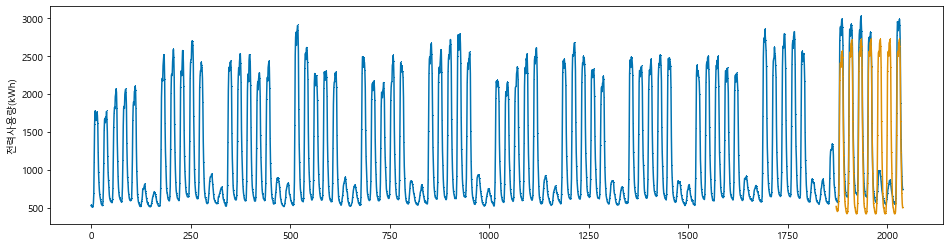

In [26]:
# 9일로 1일 예측, window = 12, units = 64, patience=15, batch = 32
# loss: 0.1076 - mae: 0.1076 - val_loss: 0.0864 - val_mae: 0.0864
plt.rc('font', family='Malgun Gothic')

plot_series(R6, P6, markers=[',' , ','])
plt.show()

## 4. LSTM

In [43]:
tf.random.set_seed(0)

model = Sequential([
    LSTM(128, return_sequences=False, recurrent_dropout=0.2),
    Dense(output_window*1, kernel_initializer=tf.initializers.zeros()),
    Reshape([output_window, 1])
])
                   
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# 검증 손실이 50epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15)         

In [44]:
model.fit(train_window_x, train_window_y, epochs=600, batch_size=32, validation_split=0.2, verbose=1,
         callbacks=[PrintDot(), early_stop, save_best_only, reduceLR])
model.summary()

Epoch 1/600
4/4 [==============================] - 1s 319ms/step - loss: 0.2672 - mae: 0.2672 - val_loss: 0.2557 - val_mae: 0.2557
Epoch 2/600
4/4 [==============================] - 1s 268ms/step - loss: 0.2342 - mae: 0.2342 - val_loss: 0.2263 - val_mae: 0.2263
Epoch 3/600
4/4 [==============================] - 1s 249ms/step - loss: 0.2243 - mae: 0.2243 - val_loss: 0.2245 - val_mae: 0.2245
Epoch 4/600
4/4 [==============================] - 1s 308ms/step - loss: 0.2222 - mae: 0.2222 - val_loss: 0.2229 - val_mae: 0.2229
Epoch 5/600
4/4 [==============================] - 1s 347ms/step - loss: 0.2215 - mae: 0.2215 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 6/600
4/4 [==============================] - 1s 349ms/step - loss: 0.2172 - mae: 0.2172 - val_loss: 0.2227 - val_mae: 0.2227
Epoch 7/600
4/4 [==============================] - 1s 324ms/step - loss: 0.2124 - mae: 0.2124 - val_loss: 0.2070 - val_mae: 0.2070
Epoch 8/600
4/4 [==============================] - 1s 315ms/step - loss: 0.2106 - m

Epoch 60/600
4/4 [==============================] - 2s 430ms/step - loss: 0.0582 - mae: 0.0582 - val_loss: 0.0671 - val_mae: 0.0671
Epoch 61/600
4/4 [==============================] - 2s 439ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 62/600
4/4 [==============================] - 2s 433ms/step - loss: 0.0586 - mae: 0.0586 - val_loss: 0.0661 - val_mae: 0.0661
Epoch 63/600
4/4 [==============================] - 2s 433ms/step - loss: 0.0585 - mae: 0.0585 - val_loss: 0.0651 - val_mae: 0.0651
Epoch 64/600
4/4 [==============================] - 2s 430ms/step - loss: 0.0581 - mae: 0.0581 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 65/600
4/4 [==============================] - 2s 437ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0659 - val_mae: 0.0659
Epoch 66/600
4/4 [==============================] - 2s 426ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0647 - val_mae: 0.0647
Epoch 67/600
4/4 [==============================] - 2s 420ms/step - loss: 0.

4/4 [==============================] - 2s 462ms/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.0625 - val_mae: 0.0625
Epoch 119/600
4/4 [==============================] - 2s 496ms/step - loss: 0.0511 - mae: 0.0511 - val_loss: 0.0627 - val_mae: 0.0627
Epoch 120/600
4/4 [==============================] - 2s 498ms/step - loss: 0.0522 - mae: 0.0522 - val_loss: 0.0626 - val_mae: 0.0626
Epoch 121/600
4/4 [==============================] - 2s 541ms/step - loss: 0.0500 - mae: 0.0500 - val_loss: 0.0624 - val_mae: 0.0624
Epoch 122/600
4/4 [==============================] - 2s 450ms/step - loss: 0.0516 - mae: 0.0516 - val_loss: 0.0623 - val_mae: 0.0623
Epoch 123/600
4/4 [==============================] - 2s 420ms/step - loss: 0.0511 - mae: 0.0511 - val_loss: 0.0624 - val_mae: 0.0624
Epoch 124/600
4/4 [==============================] - 2s 431ms/step - loss: 0.0510 - mae: 0.0510 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 125/600
4/4 [==============================] - 2s 428ms/step - loss: 0.0530 -

In [45]:
new_test_x = tf.reshape(train.iloc[:, 2].values, [1, 24*78, 1])
print(f'train_x.shape:{new_test_x.shape}')

train_x.shape:(1, 1872, 1)


In [46]:
prediction = np.zeros((1, 168, 1))

for i in range(168//output_window):
    start_ = i*output_window
    next_ = model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction = prediction *size + mini

(1, 1896, 1)
(1, 1920, 1)
(1, 1944, 1)
(1, 1968, 1)
(1, 1992, 1)
(1, 2016, 1)
(1, 2040, 1)


In [47]:
test6['prediction'] = prediction.reshape([-1, 1])
test6

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,prediction
12072,6,2020-08-18 00,596.70,25.2,0.6,95.0,0.0,0.0,0.0,0.0,542.861935
12073,6,2020-08-18 01,585.90,24.5,0.7,97.0,0.0,0.0,0.0,0.0,515.241822
12074,6,2020-08-18 02,582.12,24.3,0.5,98.0,0.0,0.0,0.0,0.0,507.341932
12075,6,2020-08-18 03,570.24,23.9,0.4,99.0,0.0,0.0,0.0,0.0,501.906129
12076,6,2020-08-18 04,565.92,23.7,0.2,100.0,0.0,0.0,0.0,0.0,498.305044
...,...,...,...,...,...,...,...,...,...,...,...
12235,6,2020-08-24 19,1399.14,29.2,1.0,72.0,0.0,0.6,0.0,0.0,1123.768713
12236,6,2020-08-24 20,1124.82,28.0,0.1,79.0,0.0,0.0,0.0,0.0,922.042434
12237,6,2020-08-24 21,905.58,27.6,0.1,82.0,0.0,0.0,0.0,0.0,757.547538
12238,6,2020-08-24 22,790.02,27.5,0.4,84.0,0.0,0.0,0.0,0.0,665.692051


In [48]:
train = pd.read_csv('energy/train.csv', encoding = 'CP949')
building6 = train.iloc[10200:12240,:]

a = list(range(1872, 2040))
test6.index = a

In [49]:
building6.reset_index(inplace=True)
building6 = building6.drop(['index'], axis=1)
building6

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,6,2020-06-01 00,527.58,17.0,2.0,100.0,1.1,0.0,0.0,0.0
1,6,2020-06-01 01,518.94,17.2,2.3,99.0,0.1,0.0,0.0,0.0
2,6,2020-06-01 02,511.38,17.2,3.7,98.0,0.0,0.0,0.0,0.0
3,6,2020-06-01 03,514.62,16.7,3.1,99.0,0.0,0.0,0.0,0.0
4,6,2020-06-01 04,503.82,16.9,3.5,98.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,6,2020-08-24 19,1399.14,29.2,1.0,72.0,0.0,0.6,0.0,0.0
2036,6,2020-08-24 20,1124.82,28.0,0.1,79.0,0.0,0.0,0.0,0.0
2037,6,2020-08-24 21,905.58,27.6,0.1,82.0,0.0,0.0,0.0,0.0
2038,6,2020-08-24 22,790.02,27.5,0.4,84.0,0.0,0.0,0.0,0.0


In [50]:
R6 = building6['전력사용량(kWh)']
P6 = test6['prediction']

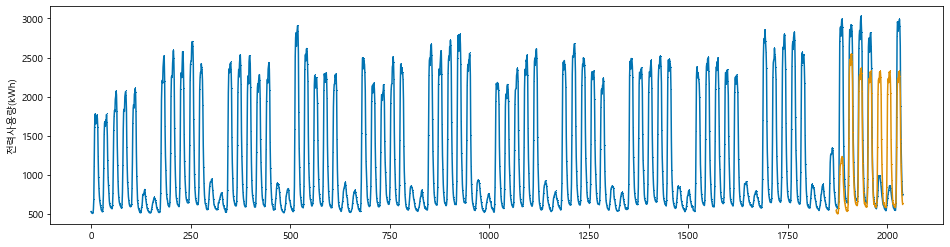

In [51]:
# 9일로 1일 예측, window = 12, units = 128, patience=15, batch = 32
# loss: 0.0468 - mae: 0.0468 - val_loss: 0.0522 - val_mae: 0.0522
plt.rc('font', family='Malgun Gothic')

plot_series(R6, P6, markers=[',' , ','])
plt.show()

#### 밑에 그래프들은 튜닝하다가 비슷하게 예측한것 같아서 위에 loss값 제일 잘나온걸로 선택

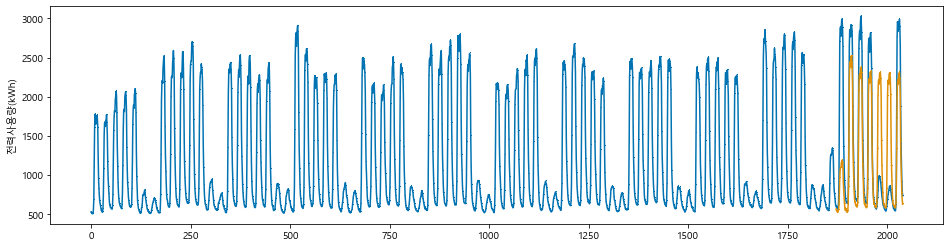

In [106]:
# 9일로 1일 예측, window = 12, units = 128, patience=15, batch = 64
# loss: 0.0497 - mae: 0.0497 - val_loss: 0.0528 - val_mae: 0.0528
#plt.rc('font', family='Malgun Gothic')

#plot_series(R6, P6, markers=[',' , ','])
#plt.show()

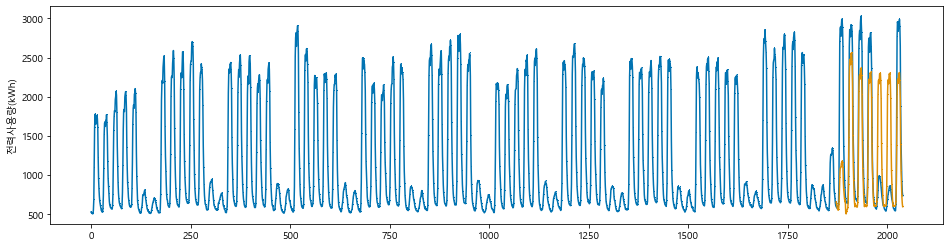

In [80]:
# 9일로 1일 예측, window = 8, units = 128, patience=15, batch = 32
# loss: 0.0627 - mae: 0.0627 - val_loss: 0.0678 - val_mae: 0.0678
#plt.rc('font', family='Malgun Gothic')

#plot_series(R6, P6, markers=[',' , ','])
#plt.show()

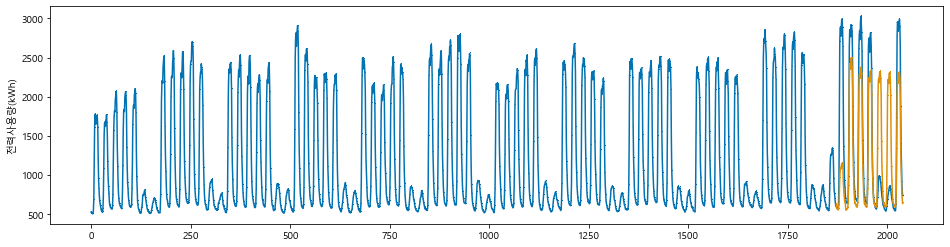

In [28]:
# 8일로 1일 예측, window = 8, units = 128, patience=15, batch = 64
# loss: 0.0604 - mae: 0.0604 - val_loss: 0.0644 - val_mae: 0.0644
#plt.rc('font', family='Malgun Gothic')

#plot_series(R6, P6, markers=[',' , ','])
#plt.show()